# SAM8905 Reverb FX - ALG 1 Analysis (Diffusion)

This notebook analyzes ALG 1 of the Keyfox10 reverb effect.

**ALG 1 Purpose:** Diffusion/scatter processing - spreads early reflections for a more natural reverb sound.

**Key characteristics:**
- Located at A-RAM 0x40-0x7F (22kHz ALG 1)
- Used by Slot 5 (D-RAM ALG=2)
- Heavy DAC output: 13 WACC instructions
- No WXY+WSP combo (uses MIX values from previous slot)
- Reads from D-RAM and SRAM for extensive multiply-accumulate operations

In [21]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import sam8905_interpreter
reload(sam8905_interpreter)

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    export_wav,
    print_state,
    print_dram_changes
)
from sam8905_aram_decoder import decode_algorithm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## ALG 1 from Keyfox10 FX Chip

A-RAM addresses 0x40-0x7F (64 instructions for 22kHz ALG 1)

In [22]:
# A-RAM 0x40-0x7F: 22kHz ALG 1 (D-RAM ALG=2, Used by Slot 5 - Diffusion)
# From WIP_fx_reverb_analysis.md
aram_alg1 = [
    0x30EF,  # PC00: RM 6, <WPHI>                      - PHI = D[6]
    0x48FD,  # PC01: RM 9, <WWF>                       - WWF = D[9] (waveform config)
    0x6ADF,  # PC02: RADD 13, <WM>                     - D[13] = A+B
    0x703F,  # PC03: RM 14, <WA, WB>                   - A=B=D[14]
    0x0000,  # PC04: RM 0, <WA,WB,WM,WPHI,WXY,clrB,WWF,WACC>  - WACC #1
    0x6BDF,  # PC05: RADD 13, <WM> [WSP]               - D[13] = A+B, WSP active
    0x38EF,  # PC06: RM 7, <WPHI>                      - PHI = D[7]
    0x50FC,  # PC07: RM 10, <WWF,WACC>                 - WWF=D[10], WACC #2
    0x687F,  # PC08: RM 13, <WA>                       - A = D[13]
    0x7CBE,  # PC09: RP 15, <WB,WACC>                  - B = product, WACC #3
    0x18F7,  # PC10: RM 3, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC11: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC12: RM 8, <WPHI>                      - PHI = D[8]
    0x58FC,  # PC13: RM 11, <WWF,WACC>                 - WWF=D[11], WACC #4
    0x7CBE,  # PC14: RP 15, <WB,WACC>                  - B = product, WACC #5
    0x6ADF,  # PC15: RADD 13, <WM>                     - D[13] = A+B
    0x18F7,  # PC16: RM 3, <WXY>                       - WXY - waveform read
    0x00BF,  # PC17: RM 0, <WB>                        - B = D[0]
    0x307F,  # PC18: RM 6, <WA>                        - A = D[6]
    0x32CE,  # PC19: RADD 6, <WM,WPHI,WACC>            - D[6]=A+B, PHI=bus, WACC #6
    0x48FC,  # PC20: RM 9, <WWF,WACC>                  - WWF=D[9], WACC #7
    0x387F,  # PC21: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC22: RADD 7, <WM>                      - D[7] = A+B
    0x407F,  # PC23: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC24: RADD 8, <WM>                      - D[8] = A+B
    0x7CBF,  # PC25: RP 15, <WB>                       - B = product
    0x20F7,  # PC26: RM 4, <WXY>                       - WXY - waveform read
    0x687F,  # PC27: RM 13, <WA>                       - A = D[13]
    0x38EF,  # PC28: RM 7, <WPHI>                      - PHI = D[7]
    0x50FD,  # PC29: RM 10, <WWF>                      - WWF = D[10]
    0x7A7E,  # PC30: RADD 15, <WA,WACC>                - A=A+B, WACC #8
    0x7CBE,  # PC31: RP 15, <WB,WACC>                  - B = product, WACC #9
    0x28F7,  # PC32: RM 5, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC33: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC34: RM 8, <WPHI>                      - PHI = D[8]
    0x58FD,  # PC35: RM 11, <WWF>                      - WWF = D[11]
    0x7CBE,  # PC36: RP 15, <WB,WACC>                  - B = product, WACC #10
    0x6ADE,  # PC37: RADD 13, <WM,WACC>                - D[13]=A+B, WACC #11
    0x28F7,  # PC38: RM 5, <WXY>                       - WXY - waveform read
    0x08BF,  # PC39: RM 1, <WB>                        - B = D[1]
    0x307F,  # PC40: RM 6, <WA>                        - A = D[6]
    0x32DF,  # PC41: RADD 6, <WM>                      - D[6] = A+B
    0x493F,  # PC42: RM 9, <WA,WB> [WSP]               - A=B=D[9], WSP active
    0x4ADF,  # PC43: RADD 9, <WM>                      - D[9] = A+B
    0x60BF,  # PC44: RM 12, <WB>                       - B = D[12]
    0x4BDF,  # PC45: RADD 9, <WM> [WSP]                - D[9]=A+B, WSP active
    0x08BF,  # PC46: RM 1, <WB>                        - B = D[1]
    0x387F,  # PC47: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC48: RADD 7, <WM>                      - D[7] = A+B
    0x513F,  # PC49: RM 10, <WA,WB> [WSP]              - A=B=D[10], WSP active
    0x52DF,  # PC50: RADD 10, <WM>                     - D[10] = A+B
    0x60BF,  # PC51: RM 12, <WB>                       - B = D[12]
    0x53DF,  # PC52: RADD 10, <WM> [WSP]               - D[10]=A+B, WSP active
    0x08BF,  # PC53: RM 1, <WB>                        - B = D[1]
    0x407F,  # PC54: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC55: RADD 8, <WM>                      - D[8] = A+B
    0x593F,  # PC56: RM 11, <WA,WB> [WSP]              - A=B=D[11], WSP active
    0x5ADF,  # PC57: RADD 11, <WM>                     - D[11] = A+B
    0x60BF,  # PC58: RM 12, <WB>                       - B = D[12]
    0x5BDF,  # PC59: RADD 11, <WM> [WSP]               - D[11]=A+B, WSP active
    0x7CBE,  # PC60: RP 15, <WB,WACC>                  - B = product, WACC #12
    0x687E,  # PC61: RM 13, <WA,WACC>                  - A = D[13], WACC #13
]

# Pad to 64 instructions (PC62-63 are reserved NOPs)
aram_alg1 += [0x7FFF] * (64 - len(aram_alg1))

print(f"ALG 1: {len(aram_alg1)} instructions")
print()
print(decode_algorithm(aram_alg1, 1))

ALG 1: 64 instructions

=== Algorithm 1 ===

PC00: 30EF  RM 6, <WPHI>
PC01: 48FD  RM 9, <WWF>
PC02: 6ADF  RADD 13, <WM>
PC03: 703F  RM 14, <WA, WB>
PC04: 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
PC05: 6BDF  RADD 13, <WM, WSP> ***
PC06: 38EF  RM 7, <WPHI>
PC07: 50FC  RM 10, <WWF, WACC>
PC08: 687F  RM 13, <WA>
PC09: 7CBE  RP, <WB, WACC>
PC10: 18F7  RM 3, <WXY>
PC11: 7A7F  RADD, <WA>
PC12: 40EF  RM 8, <WPHI>
PC13: 58FC  RM 11, <WWF, WACC>
PC14: 7CBE  RP, <WB, WACC>
PC15: 6ADF  RADD 13, <WM>
PC16: 18F7  RM 3, <WXY>
PC17: 00BF  RM 0, <WB>
PC18: 307F  RM 6, <WA>
PC19: 32CE  RADD 6, <WM, WPHI, WACC>
PC20: 48FC  RM 9, <WWF, WACC>
PC21: 387F  RM 7, <WA>
PC22: 3ADF  RADD 7, <WM>
PC23: 407F  RM 8, <WA>
PC24: 42DF  RADD 8, <WM>
PC25: 7CBF  RP, <WB>
PC26: 20F7  RM 4, <WXY>
PC27: 687F  RM 13, <WA>
PC28: 38EF  RM 7, <WPHI>
PC29: 50FD  RM 10, <WWF>
PC30: 7A7E  RADD, <WA, WACC>
PC31: 7CBE  RP, <WB, WACC>
PC32: 28F7  RM 5, <WXY>
PC33: 7A7F  RADD, <WA>
PC34: 40EF  RM 8, <WPHI>
PC35: 58FD  R

## D-RAM Configuration (Slot 5 - Diffusion)

In [23]:
# D-RAM for Slot 5 (ALG 1 / Diffusion)
# From WIP_fx_reverb_analysis.md
dram_slot5 = [
    0x00080,  # word 0: PHI offset / constant
    0x00180,  # word 1: Modulation offset
    0x1003F,  # word 2: WWF config (external waveform)
    0x10000,  # word 3: Amplitude (Y=0x200 = +0.25 Q0.11)
    0x00100,  # word 4: Amplitude (Y=0x002 = +0.001 Q0.11)
    0x00100,  # word 5: Amplitude (Y=0x002 = +0.001 Q0.11)
    0x3FF00,  # word 6: Large delay address
    0x6DF00,  # word 7: Delay address (phase modulation)
    0x5A100,  # word 8: Delay address (phase modulation)
    0x40402,  # word 9: WWF/SRAM bank config
    0x40402,  # word 10: WWF/SRAM bank config
    0x40402,  # word 11: WWF/SRAM bank config
    0x40402,  # word 12: Modulation depth
    0x00000,  # word 13: Working accumulator
    0x40000,  # word 14: Feedback state
    0x3C280,  # word 15: 0011 1100 0010 1000 0000 → IDLE=0, ALG=2 (22kHz ALG 1)
]

print("D-RAM Slot 5 configuration:")
for i, val in enumerate(dram_slot5):
    signed_val = val if val < 0x40000 else val - 0x80000
    # Also show Y value (bits 18:7) for amplitude words
    y_val = (val >> 7) & 0xFFF
    y_signed = y_val if y_val < 0x800 else y_val - 0x1000
    q011 = y_signed / 2048.0
    print(f"  D[{i:2d}] = 0x{val:05X} (signed: {signed_val:+8d}, Y={y_signed:+5d} = {q011:+.4f} Q0.11)")

D-RAM Slot 5 configuration:
  D[ 0] = 0x00080 (signed:     +128, Y=   +1 = +0.0005 Q0.11)
  D[ 1] = 0x00180 (signed:     +384, Y=   +3 = +0.0015 Q0.11)
  D[ 2] = 0x1003F (signed:   +65599, Y= +512 = +0.2500 Q0.11)
  D[ 3] = 0x10000 (signed:   +65536, Y= +512 = +0.2500 Q0.11)
  D[ 4] = 0x00100 (signed:     +256, Y=   +2 = +0.0010 Q0.11)
  D[ 5] = 0x00100 (signed:     +256, Y=   +2 = +0.0010 Q0.11)
  D[ 6] = 0x3FF00 (signed:  +261888, Y=+2046 = +0.9990 Q0.11)
  D[ 7] = 0x6DF00 (signed:   -73984, Y= -578 = -0.2822 Q0.11)
  D[ 8] = 0x5A100 (signed:  -155392, Y=-1214 = -0.5928 Q0.11)
  D[ 9] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[10] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[11] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[12] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[13] = 0x00000 (signed:       +0, Y=   +0 = +0.0000 Q0.11)
  D[14] = 0x40000 (signed:  -262144, Y=-2048 = -1.0000 Q0.11)
  D[15] = 0x3C280 (signed:  +246400, Y=+19

## SRAM Buffer Setup

ALG 1 reads from external SRAM using WF=0x02 (bank 2), where ALG 0 writes input samples.

**Address format:** `WF[7:0] << 12 | PHI[11:0]`
- WF < 0x80: SRAM delay buffer (ALG 1 uses WF=0x02)
- WF >= 0x80: Direct input sample buffer (used by ALG 0, not ALG 1)

**Data format (matching ALG 0's output):**
- PHI[0]=0: High byte of 16-bit sample (sign-extended)
- PHI[0]=1: Low byte of 16-bit sample
- 8-bit SRAM data is shifted left 3 bits to 12-bit SAM format

In [70]:
# Load SRAM buffer that was populated by ALG 0
# This ensures we're using the exact same data format

import pickle
import numpy as np

# Load the SRAM buffer saved by ALG 0
with open('alg0_sram_buffer.pkl', 'rb') as f:
    alg0_sram = pickle.load(f)

print(f"Loaded ALG 0 SRAM buffer: {len(alg0_sram)} entries")
print(f"Address range: 0x{min(alg0_sram.keys()):04X} - 0x{max(alg0_sram.keys()):04X}")

# SRAM address format (32KB = 15 bits): (WF[2:0] << 12) | PHI[11:0]
# Both ALG 0 writes and ALG 1 reads use this format now

# Logging
sram_read_log = []
input_read_log = []
frame_counter = 0

def waveform_read_callback(address):
    """External waveform read callback.
    
    Address format: WF[7:0] << 12 | PHI[11:0]
    - WF 0x00-0x7F: SRAM delay buffer (lower 15 bits = SRAM address)
    - WF 0x80-0xFF: Direct input (16-bit, high/low byte select via PHI[0])
    
    SRAM address format (32KB = 15 bits):
    - Address bits [14:0] = (WF[2:0] << 12) | PHI[11:0]
    """
    global frame_counter
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # Direct input - not used by ALG 1
        return 0
    else:
        # SRAM delay buffer read
        # Use lower 15 bits of address directly
        sram_addr = address & 0x7FFF
        
        # Get stored value (12-bit)
        result = alg0_sram.get(sram_addr, 0)
        
        sram_read_log.append((frame_counter, address, result, wf, phi, sram_addr))

        if not (phi & 1):
            # Sign-extend 8-bit to 12-bit
            if result & 0x80:
                result |= 0xF00
        
        result <<= 3
        return result & 0xFFF

# Show sample values
print("\nSample SRAM reads (direct address lookup):")
test_addrs = [0x2002, 0x2003, 0x2006, 0x2FFE, 0x2FFF]
for addr in test_addrs:
    val = alg0_sram.get(addr, 0)
    val_signed = val if val < 2048 else val - 4096
    print(f"  SRAM[0x{addr:04X}] = 0x{val:03X} ({val_signed:+5d})")

Loaded ALG 0 SRAM buffer: 2048 entries
Address range: 0x2002 - 0x2FFF

Sample SRAM reads (direct address lookup):
  SRAM[0x2002] = 0x03F (  +63)
  SRAM[0x2003] = 0xF1E ( -226)
  SRAM[0x2006] = 0x000 (   +0)
  SRAM[0x2FFE] = 0x04C (  +76)
  SRAM[0x2FFF] = 0xC7A ( -902)


## Run ALG 1 (Diffusion)

Execute the algorithm and collect output samples.

In [46]:
# Create interpreter and configure
sam = SAM8905Interpreter()

# Set 22kHz mode (CRITICAL: must set on state, not interpreter)
sam.state.control_reg = 0x08  # SSR=1 for 22.05kHz mode

# Load ALG 1 at offset 64 (0x40 for 22kHz ALG 1)
sam.load_aram(aram_alg1, offset=64)

# Load D-RAM for slot 5
sam.load_dram(5, dram_slot5)

# Set up SRAM read callback
sam.waveform_read = waveform_read_callback

print("Interpreter configured:")
print(f"  A-RAM loaded at offset 64 (ALG 1)")
print(f"  D-RAM slot 5 loaded")
print(f"  Waveform read callback active")
print(f"  control_reg: 0x{sam.state.control_reg:02X} (22kHz mode)")

Interpreter configured:
  A-RAM loaded at offset 64 (ALG 1)
  D-RAM slot 5 loaded
  Waveform read callback active
  control_reg: 0x08 (22kHz mode)


In [47]:
# Reset and run
sam.reset()
sam.state.control_reg = 0x08  # Set 22kHz mode AFTER reset
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback

# ALG 1 has no WXY+WSP instruction to set MIX values
# In the real reverb chain, MIX would be set by slot 4 (ALG 0)
# For testing, manually set MIX to enable output
sam.state.mix_l = 7  # 0dB (full volume)
sam.state.mix_r = 7  # 0dB

# Clear logs
sram_read_log.clear()
input_read_log.clear()
frame_counter = 0

# Generate samples - one frame at a time to track frame counter
NUM_FRAMES = 500
samples_list = []

for i in range(NUM_FRAMES):
    frame_counter = i  # Update global counter before each frame
    frame_samples = sam.run(1, active_slots=[5])
    samples_list.append(frame_samples[0])

samples = np.array(samples_list)

print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"SRAM delay buffer reads: {len(sram_read_log)}")
print(f"Input sample reads: {len(input_read_log)}")

Generated 500 samples
L range: [-416, 420]
R range: [-416, 420]
SRAM delay buffer reads: 3000
Input sample reads: 0


## Output Visualization

ALG 1 has 13 WACC instructions - the most of any reverb algorithm. This produces dense output for the diffusion effect.

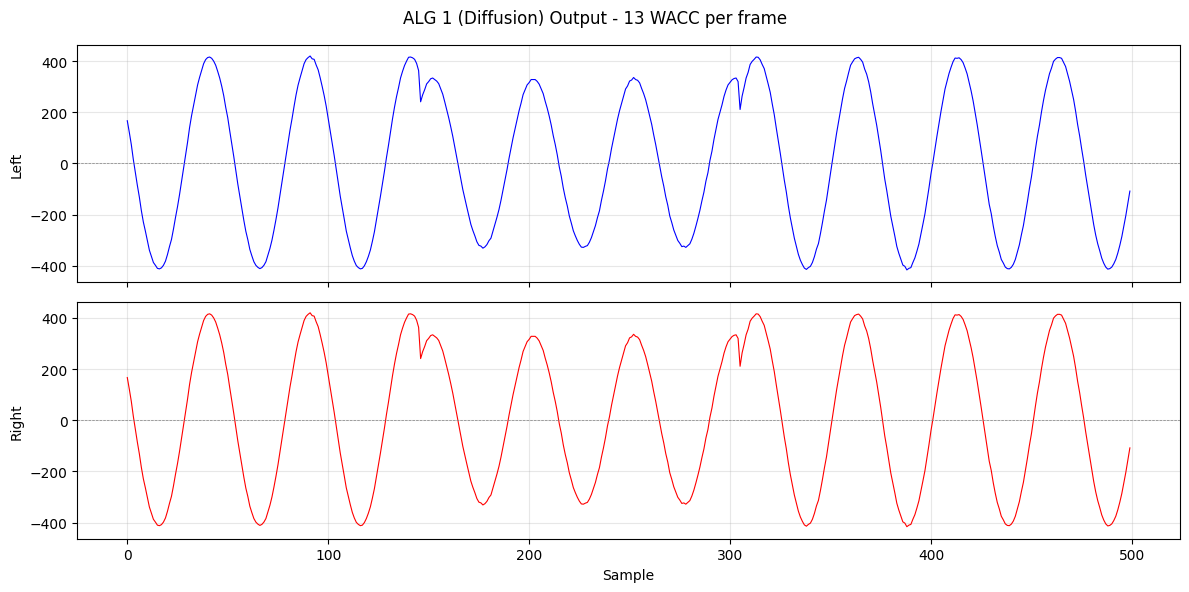


Signal Statistics:
  L channel: min=-416, max=420, mean=4.06, std=277.81
  R channel: min=-416, max=420, mean=4.06, std=277.81


In [48]:
# Plot output waveform with appropriate y-axis scaling
# ALG 1 output range depends on SRAM content and mix settings
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Auto-scale based on actual data range with some padding
y_max = max(abs(samples[:, 0].min()), abs(samples[:, 0].max()),
            abs(samples[:, 1].min()), abs(samples[:, 1].max()))
y_lim = 1 + y_max * 1.1  # 10% padding

ax1.plot(samples[:, 0], 'b-', linewidth=0.8)
ax1.set_ylabel('Left')
ax1.set_ylim(-y_lim, y_lim)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax1.grid(True, alpha=0.3)

ax2.plot(samples[:, 1], 'r-', linewidth=0.8)
ax2.set_ylabel('Right')
ax2.set_xlabel('Sample')
ax2.set_ylim(-y_lim, y_lim)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.grid(True, alpha=0.3)

fig.suptitle("ALG 1 (Diffusion) Output - 13 WACC per frame")
plt.tight_layout()
plt.show()

# Show signal statistics
print("\nSignal Statistics:")
print(f"  L channel: min={samples[:, 0].min()}, max={samples[:, 0].max()}, mean={samples[:, 0].mean():.2f}, std={samples[:, 0].std():.2f}")
print(f"  R channel: min={samples[:, 1].min()}, max={samples[:, 1].max()}, mean={samples[:, 1].mean():.2f}, std={samples[:, 1].std():.2f}")

## SRAM Read Analysis

Examine which SRAM addresses are read by ALG 1 and how they affect the output.

In [49]:
# Analyze SRAM delay buffer reads
if sram_read_log:
    print(f"=== SRAM Delay Buffer Reads ({len(sram_read_log)} total) ===")
    
    # Count unique SRAM addresses accessed
    sram_addrs = set(e[5] for e in sram_read_log)
    print(f"Unique SRAM addresses accessed: {len(sram_addrs)}")
    print(f"SRAM address range: 0x{min(sram_addrs):04X} - 0x{max(sram_addrs):04X}")
    print(f"Reads per frame: {len(sram_read_log) / NUM_FRAMES:.1f}")
    
    # Show sample reads with address translation
    print("\nFirst 20 SRAM reads:")
    for i, entry in enumerate(sram_read_log[:20]):
        frame, addr, result, wf, phi, sram_addr = entry
        result_signed = result if result < 2048 else result - 4096
        print(f"  Frame {frame}: PHI=0x{phi:03X} -> SRAM[0x{sram_addr:04X}] = 0x{result:03X}({result_signed:+5d})")
else:
    print("No SRAM delay buffer reads recorded")

# Analyze input sample reads (shouldn't happen for ALG 1)
print()
if input_read_log:
    print(f"=== Input Sample Reads ({len(input_read_log)} total) ===")
    print("NOTE: ALG 1 should NOT read directly from input buffer!")
else:
    print("No direct input reads (expected for ALG 1 - it reads from SRAM delay buffer)")

=== SRAM Delay Buffer Reads (3000 total) ===
Unique SRAM addresses accessed: 1528
SRAM address range: 0x2001 - 0x2FFF
Reads per frame: 6.0

First 20 SRAM reads:
  Frame 0: PHI=0x001 -> SRAM[0x2001] = 0x000(   +0)
  Frame 0: PHI=0xDBE -> SRAM[0x2DBE] = 0xFF0(  -16)
  Frame 0: PHI=0xB42 -> SRAM[0x2B42] = 0x063(  +99)
  Frame 0: PHI=0x7FF -> SRAM[0x27FF] = 0xC58( -936)
  Frame 0: PHI=0xDBF -> SRAM[0x2DBF] = 0x0F6( +246)
  Frame 0: PHI=0xB43 -> SRAM[0x2B43] = 0x34C( +844)
  Frame 1: PHI=0x001 -> SRAM[0x2001] = 0x000(   +0)
  Frame 1: PHI=0xDC2 -> SRAM[0x2DC2] = 0xFE2(  -30)
  Frame 1: PHI=0xB46 -> SRAM[0x2B46] = 0x05A(  +90)
  Frame 1: PHI=0x803 -> SRAM[0x2803] = 0x246( +582)
  Frame 1: PHI=0xDC3 -> SRAM[0x2DC3] = 0x2D0( +720)
  Frame 1: PHI=0xB47 -> SRAM[0x2B47] = 0xA18(-1512)
  Frame 2: PHI=0x001 -> SRAM[0x2001] = 0x000(   +0)
  Frame 2: PHI=0xDC6 -> SRAM[0x2DC6] = 0xFD5(  -43)
  Frame 2: PHI=0xB4A -> SRAM[0x2B4A] = 0x050(  +80)
  Frame 2: PHI=0x807 -> SRAM[0x2807] = 0x690(+1680)
  Frame

## Final State Inspection

In [29]:
print_state(sam.state, slot=5)

SAM8905 Register State
  A = 0x00080  (+128)
  B = 0x00000  (+0)
  X = 0x000  (+0)
  Y = 0x002  (+2)
  PHI = 0x30F  (783)
  WF = 0x002
  MUL = 0x00000  (+0)

  CARRY = False
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 7  MIX_R = 7
  L_ACC = +0  R_ACC = +0

D-RAM Slot 5:
  D[ 0] = 0x00080  (+128)
  D[ 1] = 0x00180  (+384)
  D[ 2] = 0x1003F  (+65599)
  D[ 3] = 0x10000  (+65536)
  D[ 4] = 0x00100  (+256)
  D[ 5] = 0x00100  (+256)
  D[ 6] = 0x7E700  (-6400)
  D[ 7] = 0x2C700  (+182016)
  D[ 8] = 0x18900  (+100608)
  D[ 9] = 0x40402  (-261118)
  D[10] = 0x40402  (-261118)
  D[11] = 0x40402  (-261118)
  D[12] = 0x40402  (-261118)
  D[13] = 0x00080  (+128)
  D[14] = 0x40000  (-262144)
  D[15] = 0x3C280  (+246400)
